## Image Segmentation

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

c:\Users\kaan\anaconda3\envs\huggingface\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import pipeline

In [4]:
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77")

c:\Users\kaan\anaconda3\envs\huggingface\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kaan\.cache\huggingface\hub\models--Zigeng--SlimSAM-uniform-77. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
from PIL import Image

In [8]:
raw_image = Image.open("Llamas.jpeg")
raw_image.show()

In [9]:
raw_image = raw_image.resize((720, 375))

In [10]:
raw_image.show()

In [18]:
output = sam_pipe(raw_image, points_per_batch=32)

In [28]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np

def show_pipe_masks_on_image(image, output):
    image_copy = image.convert("RGBA")

    masks = output.get("masks", [])
    scores = output.get("scores", [])

    colors = [
        (255, 0, 0, 100),  # Kırmızı
        (0, 255, 0, 100),  # Yeşil
        (0, 0, 255, 100),  # Mavi
        (255, 255, 0, 100),  # Sarı
        (255, 0, 255, 100),  # Mor
        (0, 255, 255, 100),  # Camgöbeği
    ]

    draw = ImageDraw.Draw(image_copy)

    for i, mask in enumerate(masks):
        mask_array = np.array(mask)

        mask_image = Image.fromarray((mask_array * 255).astype(np.uint8)).convert("L")

        color = colors[i % len(colors)]
        color_layer = Image.new("RGBA", image_copy.size, color)
        mask_colored = Image.composite(color_layer, image_copy, mask_image)

        image_copy = Image.alpha_composite(image_copy, mask_colored)


        score_text = f"Score: {scores[i]:.2f}"
        mask_indices = np.argwhere(mask_array)
        if len(mask_indices) > 0:
            y_min, x_min = mask_indices.min(axis=0)
            draw.text((x_min, y_min - 10), score_text, fill="white")

    return image_copy

In [29]:
processed_image = show_pipe_masks_on_image(raw_image, output)

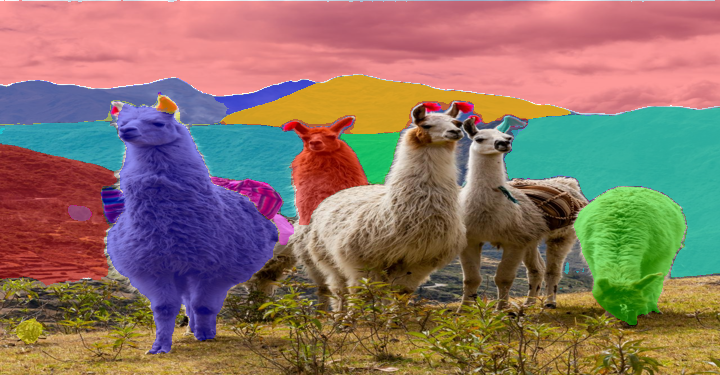

In [31]:
processed_image

In [32]:
from transformers import SamModel, SamProcessor

In [33]:
model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

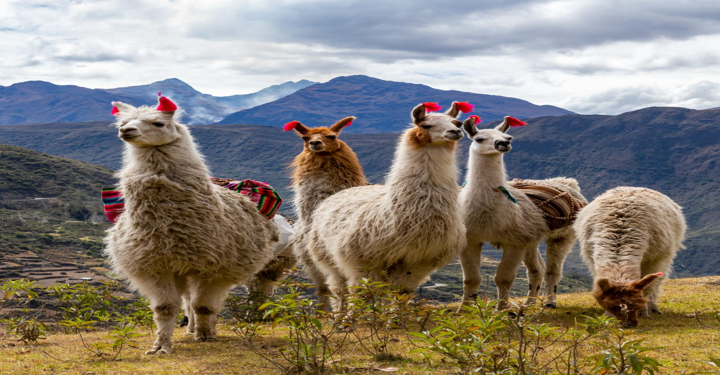

In [34]:
raw_image.resize((720, 375))

In [35]:
input_points = [[[1600, 700]]]

In [36]:
inputs = processor(raw_image,
                input_points=input_points,
                return_tensors="pt")

c:\Users\kaan\anaconda3\envs\huggingface\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [37]:
inputs

{'pixel_values': tensor([[[[2.1804, 2.1804, 2.1804,  ..., 1.1529, 1.1529, 1.1358],
          [2.1804, 2.1804, 2.1804,  ..., 1.1187, 1.1187, 1.1015],
          [2.1804, 2.1804, 2.1804,  ..., 1.0673, 1.0844, 1.0673],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.3585, 2.3585, 2.3585,  ..., 1.5182, 1.5182, 1.5007],
          [2.3585, 2.3585, 2.3585,  ..., 1.4832, 1.4832, 1.4657],
          [2.3585, 2.3585, 2.3585,  ..., 1.4307, 1.4482, 1.4307],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.6051, 2.6051, 2.6051,  ..., 2.0125, 2.0125, 1.9951],
          [2.6051, 2.6051, 2.6051,  ..., 1.9777, 1.9777, 1.9603],
          [2.6051, 2.6051

In [38]:
import torch

In [39]:
with torch.no_grad():
    outputs = model(**inputs)

In [46]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [47]:
len(predicted_masks)

1

In [48]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 375, 720])

In [49]:
outputs.iou_scores

tensor([[[0.7878, 0.7559, 0.6291]]])

In [50]:
predicted_mask

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [51]:
from PIL import Image, ImageDraw
import numpy as np

def show_pipe_masks_on_image(image, predicted_mask):
    image_copy = image.convert("RGBA")

    masks = predicted_mask.squeeze(0).numpy()

    # Renk paleti
    colors = [
        (255, 0, 0, 100),  # Kırmızı
        (0, 255, 0, 100),  # Yeşil
        (0, 0, 255, 100),  # Mavi
        (255, 255, 0, 100),  # Sarı
        (255, 0, 255, 100),  # Mor
        (0, 255, 255, 100),  # Camgöbeği
    ]

    draw = ImageDraw.Draw(image_copy)

    for i, mask in enumerate(masks):
        mask_array = mask.astype(bool)

        mask_image = Image.fromarray((mask_array * 255).astype(np.uint8)).convert("L")

        color = colors[i % len(colors)]
        color_layer = Image.new("RGBA", image_copy.size, color)
        mask_colored = Image.composite(color_layer, image_copy, mask_image)

        image_copy = Image.alpha_composite(image_copy, mask_colored)

    return image_copy

In [52]:
for i in range(3):
    sliced_mask = predicted_mask[:, :i + 1]  # İlk i maskeyi al
    processed_image = show_pipe_masks_on_image(raw_image, sliced_mask)
    processed_image.show()

### Depth Estimation with DPT

In [53]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

c:\Users\kaan\anaconda3\envs\huggingface\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kaan\.cache\huggingface\hub\models--Intel--dpt-hybrid-midas. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


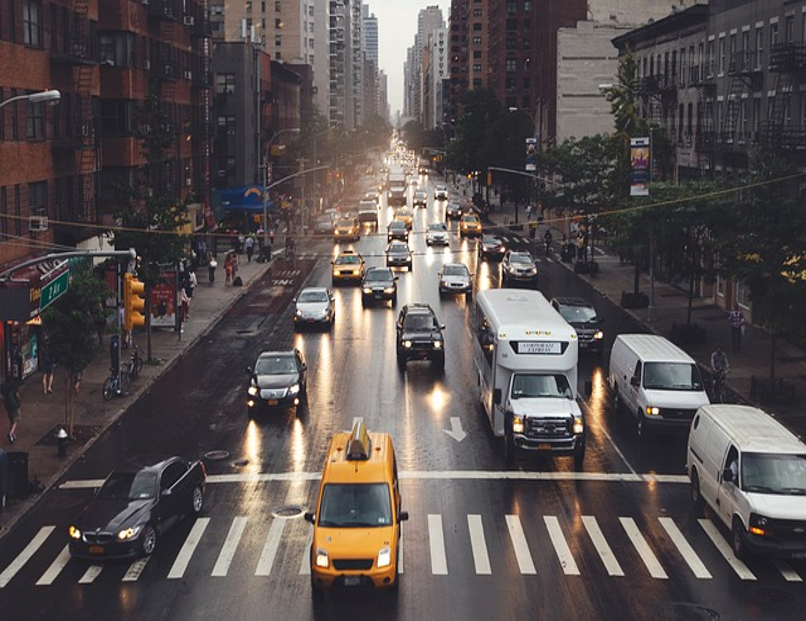

In [54]:
raw_image = Image.open('street.jpg')
raw_image.resize((806, 621))

In [55]:
output = depth_estimator(raw_image)

In [56]:
output

{'predicted_depth': tensor([[ 618.4930,  615.2312,  610.9748,  ...,  476.5224,  414.7278,
           365.8492],
         [ 599.9890,  604.7983,  610.7672,  ...,  475.1784,  470.0988,
           466.3409],
         [ 610.3538,  610.8842,  611.2360,  ...,  479.2456,  482.7669,
           485.4134],
         ...,
         [2465.6172, 2465.6367, 2465.9702,  ..., 2485.6614, 2480.8350,
          2477.3887],
         [2472.4026, 2472.3955, 2473.1589,  ..., 2491.0527, 2480.1533,
          2470.9370],
         [2451.8213, 2461.9104, 2474.8596,  ..., 2485.1982, 2474.3708,
          2466.7732]]),
 'depth': <PIL.Image.Image image mode=L size=640x426>}

In [57]:
output["predicted_depth"].shape

torch.Size([426, 640])

In [58]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([426, 1, 640])

In [59]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [640] and output size of (426, 640). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.